In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
import geopandas as gpd

In [2]:
path = '../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016'

In [3]:
ds = xr.open_dataset(path + '.nc', engine = "netcdf4")

In [4]:
sectors_pulsed = [#'BC_agr',
 'BC_ene',]
#  'BC_ind',
#  'BC_rco',
#  'BC_slv',
#  'BC_tra',
#  'BC_wst'
# ]


In [8]:
doubled = False
high_pulse = False
addition = False
complex_test = True

if doubled and high_pulse == True:
    print('ERROR: select only one option')
if doubled and addition == True:
    print('ERROR: select only one option')
if addition and high_pulse == True:
    print('ERROR: select only one option')
if addition and complex_test == True:
    print('ERROR: select only one option')
if complex_test and high_pulse == True:
    print('ERROR: select only one option')
if doubled and complex_test == True:
    print('ERROR: select only one option')

In [6]:
if high_pulse == True:
    increase_amt = 15
if doubled == True:
    increase_amt = 1
if addition == True:
    increase_amt = 1e-12
#per grid box #kg/m2/s (15 if doing pulse (total of 16x), change to 1 if doing a 2x check simulation (total of 2x), 1e-12 if doing added simulation)

## Options
We have multiple options for the type of pulse, but have determined that it doesn't make a very large difference in the outcome, so are using a weighted added pulse. This weights the pulse by the existing emissions fields. We use a 2x pulse for checks, a 15x pulse to create the functions, and a 1e-12 addition. 

# Addition

## Regional

In [7]:
if addition == True:
    ### create a pulsed dataset
    pulse_ds =  ds.drop(['BC_ind',
                         'BC_rco',
                         'BC_slv',
                         'BC_tra',
                         'BC_wst',
                         'BC_shp', 
                         'BC_agr']).copy()
    pulse_ds = pulse_ds.fillna(0)#.round(12)
    pulse_ds += increase_amt

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']


In [8]:
if addition == True:

    ### Global: Modify CEDs files
    regions = regionmask.defined_regions.ar6.land
    for r in ar6_coal_location.keys(): 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == r)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output since that is our focus
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_plus_{increase_amt}.nc')

## Country Multiplication

In [9]:
if addition == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")

In [10]:
if addition == True:

    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + r + f'_plus_{increase_amt}.nc')



# Weighted Multiplication

## Regional

In [16]:
if doubled or high_pulse == True:
    ### create a pulsed dataset
    pulse_ds =  ds.drop(['BC_ind',
                         'BC_rco',
                         'BC_slv',
                         'BC_tra',
                         'BC_wst',
                         'BC_shp', 
                         'BC_agr']).copy()
    pulse_ds = pulse_ds*increase_amt


In [16]:
if doubled or high_pulse == True:

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']
    
    
    ### Global: Modify CEDs files
    regions = regionmask.defined_regions.ar6.land
    for r in ar6_coal_location.keys(): 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == r)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            #since we add our pulse to the original, our prescribed 'increase_amt' is always 1x less than what we want as the final pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_{increase_amt+1}x.nc')

## Country Specific

In [10]:
if doubled or high_pulse == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(r"[(\[\]).]", "")
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("[/-]", " ")


4.71586311667771e-13
4.863692781853501e-12
1.8112343222465022e-12
1.0963699566268748e-12
0.0
1.716669991921882e-12


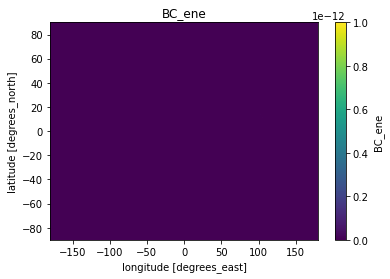

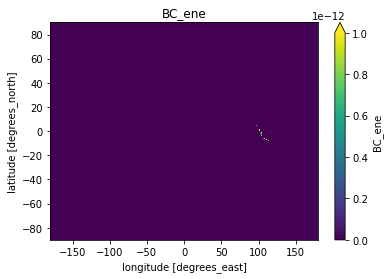

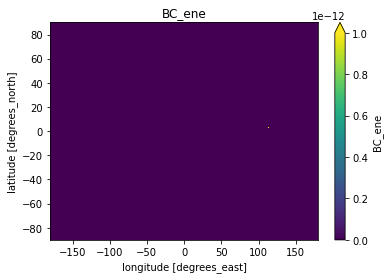

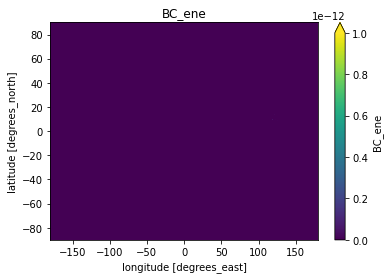

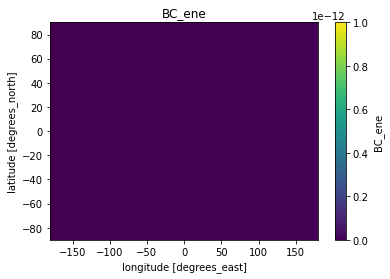

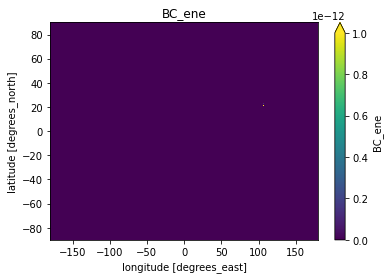

In [59]:
if doubled or high_pulse == True:
    
    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            print(((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).max().values)

            plt.title(sector)
       #ds_new.to_netcdf(path + '_' + r + f'_{increase_amt+1}x.nc')


## Country Specific choice of grid box for linearity (Indonesia)

In [11]:
if doubled or high_pulse == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(r"[(\[\]).]", "")
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("[/-]", " ")


In [12]:
print(regions['Indonesia'].bounds)
print(regions['Indonesia'].centroid)

(95.01270592500003, -10.922621351999908, 140.97762699400005, 5.910101630000042)
[114.01880911  -0.19135808]


95.01270592500003 8
140.97762699400005 -5
114.01880910588372 -0.1913580795447946


(-20.0, 10.0)

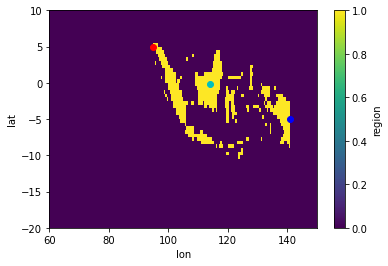

In [17]:
#choice of locations to pulse:

mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == regions['Indonesia'].number)
contiguous_mask.plot()
plt.plot(95,5,'ro')#(regions['Indonesia'].bounds[0], 8, 'ro')
print(regions['Indonesia'].bounds[0], 8)
plt.plot(regions['Indonesia'].bounds[2], -5, 'bo')
print(regions['Indonesia'].bounds[2], -5)
plt.plot(regions['Indonesia'].centroid[0], regions['Indonesia'].centroid[1], 'co')
print(regions['Indonesia'].centroid[0], regions['Indonesia'].centroid[1])
plt.xlim(60,150)
plt.ylim(-20,10)

95.01270592500003 8
140.97762699400005 -5
114.01880910588372 -0.1913580795447946


(-20.0, 10.0)

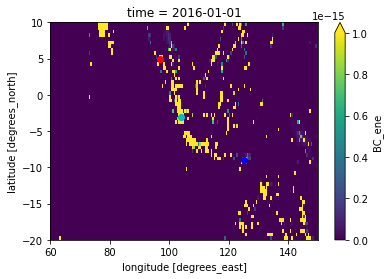

In [18]:
#choice of locations to pulse:

pulse_ds['BC_ene'].isel(time = 0).plot(vmax = 1e-15)
plt.plot(97,5,'ro')#(regions['Indonesia'].bounds[0], 8, 'ro')
print(regions['Indonesia'].bounds[0], 8)
plt.plot(125, -9, 'bo')
print(regions['Indonesia'].bounds[2], -5)
plt.plot(104, -3, 'co')
print(regions['Indonesia'].centroid[0], regions['Indonesia'].centroid[1])
plt.xlim(60,150)
plt.ylim(-20,10)

3.095011009632276e-12
2.534491349499607e-15
2.2033241117019875e-12


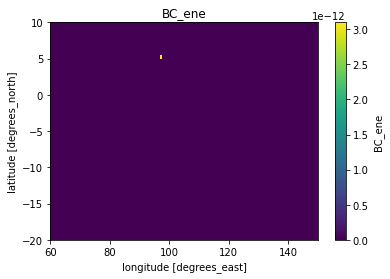

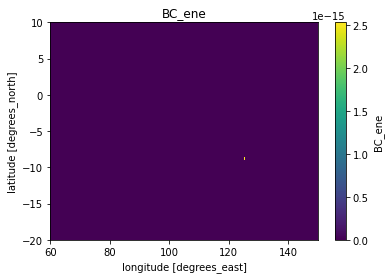

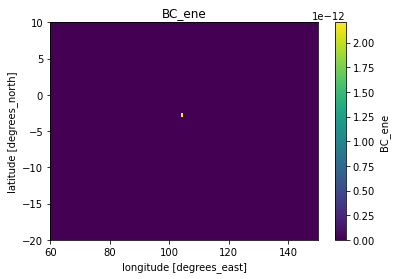

In [19]:
## Pulse at the bounds and centroid

if doubled or high_pulse == True:
    
    for lon, lat, loc in zip([97, 125, 104], [5,-9,-3], ['NW','Center','SE']):
        ds_new = ds.copy()
        ds_pulse_reg = pulse_ds.sel(lat = lat, lon = lon, method = 'nearest') #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            new_dat = ds_new[sector].loc[dict(lat=ds_pulse_reg.lat, lon=ds_pulse_reg.lon)] *(increase_amt +1) #ds.where((ds.lat==ds_pulse_reg.lat.values) & (ds.lon==ds_pulse_reg.lon.values), drop = True)* 2
            ds_new[sector].loc[dict(lat=ds_pulse_reg.lat, lon=ds_pulse_reg.lon)] = new_dat
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ds = xr.open_dataset(path + '.nc', engine = "netcdf4")
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax)
            print(((ds_new[sector]-ds[sector]).isel(time = 0)).max().values)
            plt.xlim(60,150)
            plt.ylim(-20,10)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + 'Indo' + str(loc) + f'_{increase_amt+1}x.nc')


## All country for linearity

In [11]:
# no phillipines (check why)
# no singapore bc no change

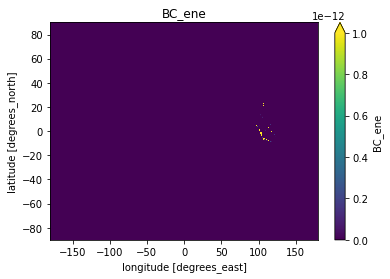

In [12]:
if doubled or high_pulse == True:
    ds_new = ds.copy()
    mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask) & ((mask == regions['Cambodia'].number) | (mask == regions['Indonesia'].number) | (mask == regions[ 'Malaysia'].number) | (mask == regions[ 'Vietnam'].number))
    ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
    for sector in sectors_pulsed:
        ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
        ds_new[sector].attrs = ds[sector].attrs
        fig, ax = plt.subplots()
        ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
        plt.title(sector)
    ds_new.to_netcdf(path + '_' + 'all_countries' + f'_{increase_amt+1}x.nc')



In [48]:
## NOTE-- Singapore does not have any difference when just the energy is pulsed ##

## check the various patterns of emissions w/ other sectors

In [72]:
ds_r = {}
for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
    ds_r[r] = xr.open_dataset(path + '_' + r + f'_{increase_amt}x_{sector}.nc')

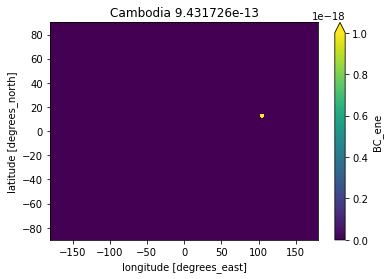

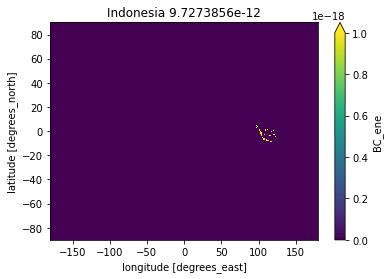

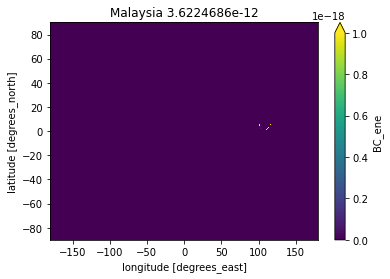

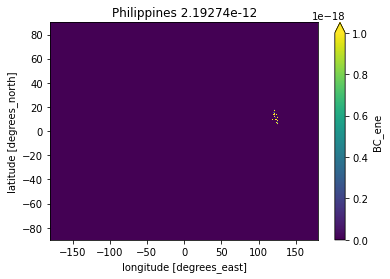

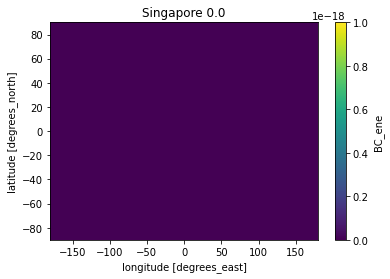

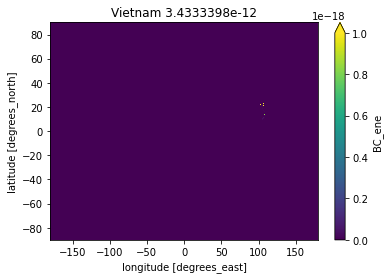

In [81]:
for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 

    fig, ax = plt.subplots()
    ((ds_r[r][sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-18)
    plt.title(r + ' ' + str(((ds_r[r][sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).values.max()))

# Complex test-- Sin and Cosin

In [14]:
### create a pulsed dataset
pulse_ds =  ds.drop(['BC_ind',
                     'BC_rco',
                     'BC_slv',
                     'BC_tra',
                     'BC_wst',
                     'BC_shp', 
                     'BC_agr']).copy()
#pulse_ds = pulse_ds*increase_amt


In [15]:
if complex_test == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(r"[(\[\]).]", "")
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("[/-]", " ")


In [21]:
mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == regions['Cambodia'].number)
ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset

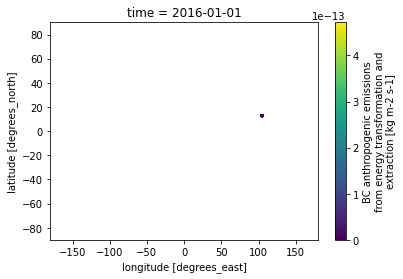

In [24]:
ds_pulse_reg.isel(time = 0)['BC_ene'].plot()

In [10]:
if doubled or high_pulse == True:
    
    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            print(((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).max().values)

            plt.title(sector)
       #ds_new.to_netcdf(path + '_' + r + f'_{increase_amt+1}x.nc')


<regionmask.Regions>
Name:     country

Regions:
  0        Ind0               Indonesia
  1        Mal0                Malaysia
  2        Chi0                   Chile
  3         Bol                 Bolivia
  4         Per                    Peru
 ..         ...                     ...
253         Mac                   Macao
254 AshandCarIs Ashmore and Cartier Is.
255   BajNueBan         Bajo Nuevo Bank
256      SerBan         Serranilla Bank
257      ScaRee        Scarborough Reef

[258 regions]

# CEDS Cosine Weighted

In [5]:
#estimated center of the US at 47 N 101 W

In [6]:
center = ds.sel(lon = -98, lat = 39, method = 'nearest')

In [7]:
lat_w = 20 #degrees (doing 2x our grid size, can change)
lon_w = 25 #degrees (doing 2x our grid size, can change)

In [8]:
A = increase_amt

In [9]:
pulse_ds = A*np.cos(np.pi/2 * (ds['lat'] - center['lat'])/lat_w)**2 * np.cos(np.pi/2 * (ds['lon'] - center['lon'])/lon_w)**2

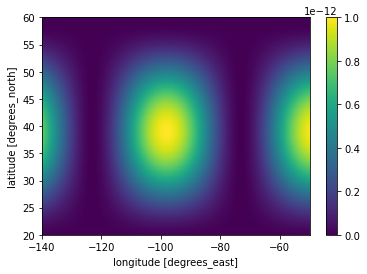

In [29]:
pulse_ds.plot()

In [10]:
us_pulse = pulse_ds.loc[dict(lat = slice(center['lat']-lat_w, center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w, center['lon']+lon_w))].rename('pulse')

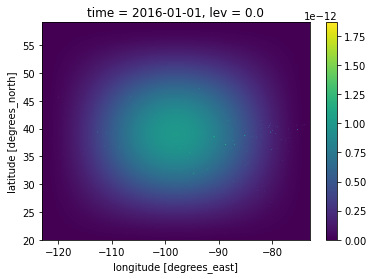

In [11]:
(ds['PEC']+pulse_ds.loc[dict(lat = slice(center['lat']-lat_w,center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w,center['lon']+lon_w))]).isel(time = 0, lev = 0).plot()

In [12]:
ds_out = xr.merge([ds['PEC'], us_pulse])

In [13]:
ds_out['pulse'] = ds_out['pulse'].fillna(0)

In [14]:
ds_out['pulse_added'] = (ds_out['PEC'] + ds_out['pulse'])

In [15]:
ds_out['pulse_added'].attrs = ds['PEC'].attrs

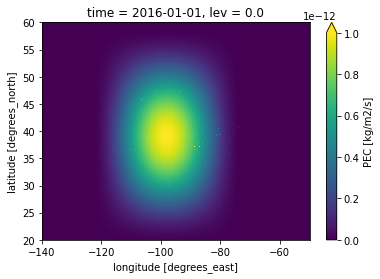

In [16]:
(ds_out['pulse_added']).isel(lev = 0).plot(vmax = 1e-12)

In [25]:
ds['PEC'] = ds_out['pulse_added'].astype('float32')

In [27]:
ds['PEC'].dtype

dtype('float32')

In [28]:
ds.to_netcdf(path + '_us_cos_pulse.nc')

# US Only, NEI Modification

01 done


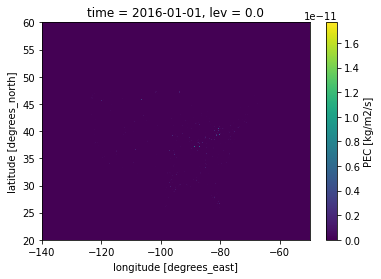

In [30]:
### US Only (modify NEI Files)
# POC for OC (in NEI)
# PEC for BC (in NEI)
poll = 'PEC'
increase_amt = 15
for m in ['01']:#,'04','07','10']:

    ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")
    ds[poll] *= increase_amt
    ds[poll].isel(time = 0, lev = 0).plot()
    #ds.to_netcdf(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}_mod_{poll}_varied.ncf')
    print(m, 'done')

In [35]:
ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")